In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

import symbolic_pofk.linear_new as linear_new
import symbolic_pofk.syren_new as syren_new
import symbolic_pofk.syren_baryon as syren_baryon

# Power spectrum suppression for different models (Figure 4 of the paper)

In this plot we show the predicted power spectrum suppression, $S(k) = P(k) / P_{\rm nbody}(k)$, for the hydro models. We also download the CAMELS data for some simulations to show how well we do. The predicted mean and sample variance are obtained with the call

```python
S_pred = syren_baryon.S_hydro(k, Om, sigma8, A_SN1, A_SN2, A_AGN1, A_AGN2, a, model)
epsilon = syren_baryon.epsilon_hydro(k, a, model)
```

and thus this is the important part of this example

Processing Astrid at z=0.0...
Processing IllustrisTNG at z=0.0...
Processing SIMBA at z=0.0...
Processing Swift-EAGLE at z=0.0...


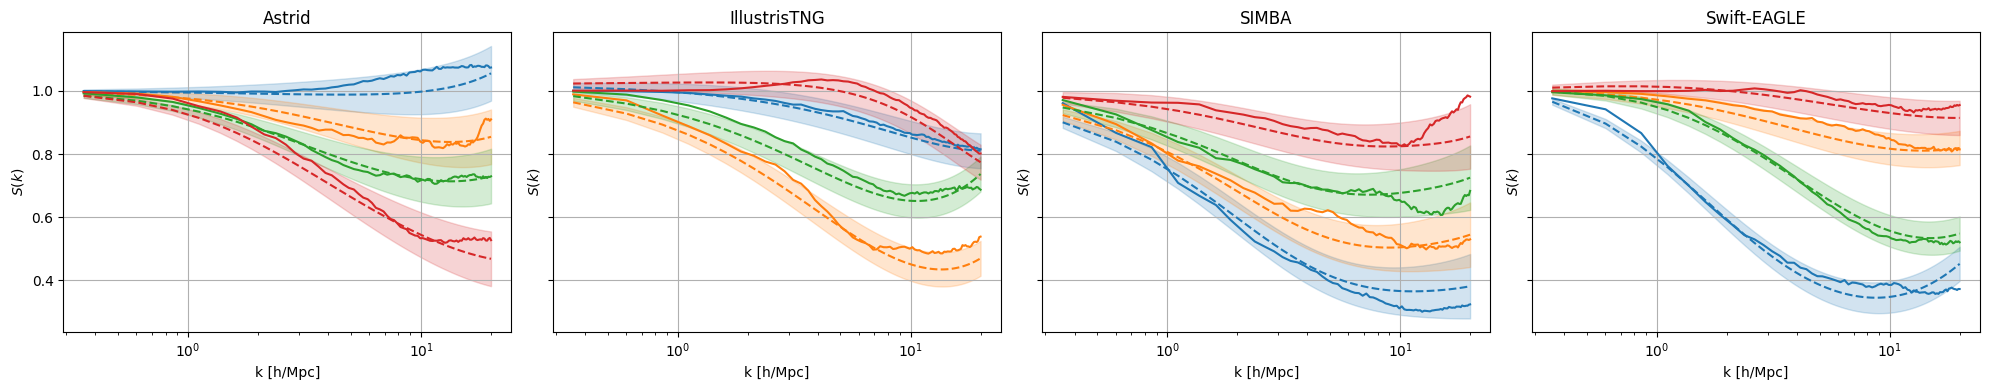

In [77]:
z = 0.0
kmax = 20

# These are the simulation numbers for each model plotted in Figure 4 of the paper
model_sims = {
    "Astrid":       [235, 171, 162, 657],
    "IllustrisTNG": [808, 299, 656, 185],
    "SIMBA":        [811, 156, 85, 138],
    "Swift-EAGLE":  [744, 246, 696, 548]
}

data_dir = 'data'
os.makedirs(data_dir, exist_ok=True)

fig, axs = plt.subplots(1, len(model_sims), figsize=(20, 4), sharey=True)

for ax, (model, all_simnum) in zip(axs, model_sims.items()):

    print(f'Processing {model} at z={z}...')

    for i, simnum in enumerate(all_simnum):
    
        outname = f'{data_dir}/Pk_{model}_{simnum}_z{z:.2f}.txt'
        if not os.path.exists(outname):
            url = f'https://users.flatironinstitute.org/~camels/Pk/{model}/L25n256/LH/LH_{simnum}/Pk_m_z={z:.2f}.txt'
            !wget -q {url} -O {outname}
        outname_DM = f'{data_dir}/Pk_{model}_DM_{simnum}_z{z:.2f}.txt'
        if not os.path.exists(outname_DM):
            url = f'https://users.flatironinstitute.org/~camels/Pk/{model}_DM/L25n256/LH/LH_{simnum}/Pk_m_z={z:.2f}.txt'
            !wget -q {url} -O {outname_DM}

        k, Pk = np.loadtxt(outname, unpack=True)
        k_DM, Pk_DM = np.loadtxt(outname_DM, unpack=True)
        assert np.all(np.isclose(k, k_DM)), "k values do not match between baryonic and DM power spectra."

        # Get parameters
        fname = f'{data_dir}/CosmoAstroSeed_{model}_L25n256_LH.txt'
        if not os.path.exists(fname):
            if model == 'Swift-EAGLE':
                url = f'https://github.com/franciscovillaescusa/CAMELS/raw/master/docs/params/EAGLE/CosmoAstroSeed_SwiftEAGLE_L25n256_LH.txt'
            else:
                url = f'https://github.com/franciscovillaescusa/CAMELS/raw/master/docs/params/{model}/CosmoAstroSeed_{model}_L25n256_LH.txt'
            !wget -q {url} -O {fname}

        with open(fname, 'r') as f:
            header = f.readline().strip().split()[1:]
            pars = f.readlines()[simnum].split()[1:]

        S = Pk / Pk_DM

        true_spectra = {
            'k': k,
            'Pk': Pk,
            'Pk_DM': Pk_DM,
            'S': S
        }

        for k, v in zip(header, pars):
            true_spectra[k] = float(v)

        k = true_spectra['k']
        S = true_spectra['S']
        m = k < kmax
        k = k[m]
        S = S[m]

        # Get prediction
        Om = true_spectra['Omega_m']
        sigma8 = true_spectra['sigma_8']
        A_SN1 = true_spectra['A_SN1']
        A_SN2 = true_spectra['A_SN2']
        A_AGN1 = true_spectra['A_AGN1']
        A_AGN2 = true_spectra['A_AGN2']
        a = 1 / (1 + z)

        S_pred = syren_baryon.S_hydro(
                k, Om, sigma8, A_SN1, A_SN2, A_AGN1, A_AGN2, a, model)
        epsilon = syren_baryon.epsilon_hydro(k, a, model)
        
        c = f'C{i}'
        ax.plot(k, S, label='S(k)', color=c)
        ax.plot(k, S_pred, label='S_pred(k)', color=c, linestyle='--')
        ax.fill_between(k, S_pred - epsilon, S_pred + epsilon, color=c, alpha=0.2, label='S_pred ± ε')
        ax.set_xscale('log')
        ax.set_title(model)


    ax.set_ylabel(r'$S(k)$')
    ax.set_xlabel('k [h/Mpc]')
    ax.grid()
fig.tight_layout()
    

# Full power spectrum example

Here we show how to generate the matter power spectrum including the linear, nonlinear and baryonic components

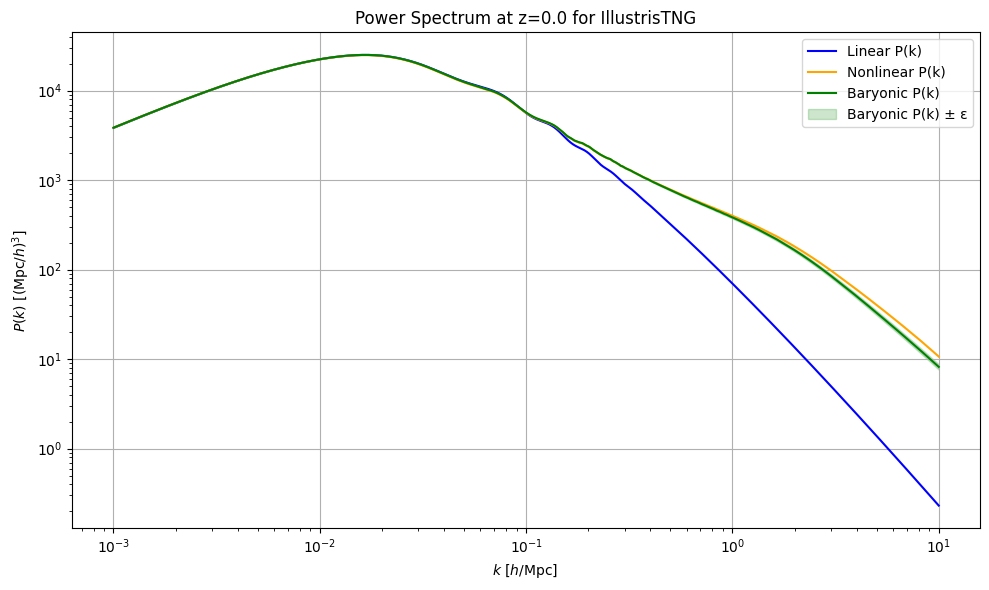

In [ ]:
# Cosmological parameters
As = 2.105  # 10^9 A_s
h = 0.6766
Om = 0.3111
Ob = 0.02242 / h ** 2
ns = 0.9665
w0 = -1.0  
wa = 0.0
mnu = 0.0

# Hydro parameters
A_SN1 = 1.0
A_SN2 = 1.0
A_AGN1 = 1.0
A_AGN2 = 1.0

# k values
k = np.logspace(-3, 1, 1000)  # k values in h/Mpc

# Redshift
z = 0.0
a = 1 / (1 + z)

# Pick a hydro model
model = 'IllustrisTNG'  # Options: 'Astrid', 'IllustrisTNG', 'SIMBA', 'Swift-EAGLE'

# Get sigma8 from As
sigma8 = linear_new.As_to_sigma8(As, Om, Ob, h, ns, mnu, w0, wa)

# Linear power spectrum
plin = linear_new.plin_new_emulated(
        k, As, Om, Ob, h, ns, mnu, w0, wa, a=a)

# Nonlinear power spectrum
pk_syren_new = syren_new.pnl_new_emulated(
        k, As, Om, Ob, h, ns, mnu, w0, wa, a)

# Baryonic effects
S = syren_baryon.S_hydro(
        k, Om, sigma8, A_SN1, A_SN2, A_AGN1, A_AGN2, a, hydro_model=model)
epsilon = syren_baryon.epsilon_hydro(k, a, hydro_model=model)
pk_baryon = pk_syren_new * S
err_baryon = pk_syren_new * epsilon

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(k, plin, label='Linear P(k)', color='blue')
plt.plot(k, pk_syren_new, label='Nonlinear P(k)', color='orange')
plt.plot(k, pk_baryon, label='Baryonic P(k)', color='green')
plt.fill_between(k, pk_baryon - err_baryon, pk_baryon + err_baryon, color='green', alpha=0.2, label='Baryonic P(k) ± ε')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$k \ [h/{\rm Mpc}]$ ')
plt.ylabel(r'$P(k) \ [({\rm Mpc}/h)^3]$')
plt.title(f'Power Spectrum at z={z} for {model}')
plt.legend()
plt.grid()
plt.tight_layout()

